# Parkinson's Disease Telemonitoring

##### In this notebook I will look at a [dataset](https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring) composed of biomedical voice measurements from 42 people with early-stage Parkinson's disease.
##### The subjects were recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patients' homes.
##### Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures.
##### Each row corresponds to one of 5,875 voice recording from these individuals. 
##### The aim is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures.


Reference:<br>
Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009) <br>
'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests' <br>
[IEEE](https://ieeexplore.ieee.org/document/5339170) Transactions on Biomedical Engineering

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from zlib import crc32
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [152]:
# Set directory to save the data
DATA_DIR = "../data/raw"

##### Fetching the data:

In [153]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# data (as pandas dataframes)
X_all = parkinsons_telemonitoring.data.features
y_all = parkinsons_telemonitoring.data.targets

# concat for easier train-test split and add subject ids column
parkinsons_all = pd.concat([X_all, y_all, parkinsons_telemonitoring.data.ids], axis=1)

# metadata
print(parkinsons_telemonitoring.metadata)

# variable information
print(parkinsons_telemonitoring.variables)

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'published_in': 'IEEE Transactions on Biomedical Engineering', 

In [154]:
parkinsons_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5875 non-null   int64  
 1   test_time      5875 non-null   float64
 2   Jitter(%)      5875 non-null   float64
 3   Jitter(Abs)    5875 non-null   float64
 4   Jitter:RAP     5875 non-null   float64
 5   Jitter:PPQ5    5875 non-null   float64
 6   Jitter:DDP     5875 non-null   float64
 7   Shimmer        5875 non-null   float64
 8   Shimmer(dB)    5875 non-null   float64
 9   Shimmer:APQ3   5875 non-null   float64
 10  Shimmer:APQ5   5875 non-null   float64
 11  Shimmer:APQ11  5875 non-null   float64
 12  Shimmer:DDA    5875 non-null   float64
 13  NHR            5875 non-null   float64
 14  HNR            5875 non-null   float64
 15  RPDE           5875 non-null   float64
 16  DFA            5875 non-null   float64
 17  PPE            5875 non-null   float64
 18  sex     

- We have 19 features, two targets (motor_UPDRS and total_UPDRS) and the subject id
- "test_time" is the time since recruitment into the trial of a given participant and so will not be a predictor
- No missing data
- 'sex' is a binary variable (0: male, 1: female), 'age' is an integer, and the remainder are floats.

### First, we must separate out a test set

#### Two standard approaches might be:
1)  Compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to x% of the maximum hash value.
2) Use stratified sampling to ensure that the relative proportions of particular demographic instances are preserved between sets, e.g. 'age' and 'sex'.

In [155]:
# Method 1.
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


# We will use the dataframe index as there is no other identifier in this data set:
parkinsons_all_with_id = parkinsons_all.reset_index()
train_set_hash, test_set_hash = split_train_test_by_id(
    parkinsons_all_with_id, 0.2, "index"
)

# Method 2.
# If we use stratified sampling based on subject id, we will get stratification by 'age' and 'sex' features automatically:
df_train, df_test = train_test_split(
    parkinsons_all_with_id, test_size=0.2, stratify=parkinsons_all["subject#"]
)

In [156]:
def proportions(data: pd.DataFrame, column: str) -> pd.Series:
    return data[column].value_counts() / len(data)

#### Now let's compare the sampling bias of the Hash and Stratified approaches:

In [157]:
col = "sex"
compare_props = pd.DataFrame(
    {
        "Overall": proportions(parkinsons_all_with_id, col),
        "Stratified": proportions(df_test, col),
        "Hash": proportions(test_set_hash, col),
    }
).sort_index()
compare_props["Hash. %error"] = (
    100 * compare_props["Hash"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)
compare_props

,Overall,Stratified,Hash,Hash. %error,Strat. %error
sex,,,,,
0,0.682213,0.682553,0.685957,0.548902,0.049900
1,0.317787,0.317447,0.314043,-1.178361,-0.107124


In [158]:
col = "age"
compare_props = pd.DataFrame(
    {
        "Overall": proportions(parkinsons_all_with_id, col),
        "Stratified": proportions(df_test, col),
        "Hash": proportions(test_set_hash, col),
    }
).sort_index()
compare_props["Hash. %error"] = (
    100 * compare_props["Hash"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)
compare_props

,Overall,Stratified,Hash,Hash. %error,Strat. %error
age,,,,,
36,0.017191,0.017021,0.018723,8.910891,-9.900990e-01
49,0.043574,0.043404,0.040851,-6.250000,-3.906250e-01
55,0.045447,0.045957,0.049362,8.614232,1.123596e+00
56,0.023830,0.023830,0.022128,-7.142857,-1.421085e-14
57,0.065532,0.065532,0.064681,-1.298701,0.000000e+00
58,0.073021,0.072340,0.072340,-0.932401,-9.324009e-01
59,0.050894,0.051064,0.051064,0.334448,3.344482e-01
60,0.026553,0.026383,0.026383,-0.641026,-6.410256e-01
61,0.025532,0.025532,0.025532,0.000000,0.000000e+00


#### The stratified sampling approach could be a reasonable way forwards; however, in the real world, the model would be applied to new patients who were not participants in the trial. If there are patterns in the data, specific to trial participants, and that data was split between training and testing data sets for evaluation, there would be potential data leakage issues. For that reason, I will create a train-test split based on subject (participant) ID.

Before splitting on subject ID, let's check that there is not a great disparity between number of data points per participant:

Text(0, 0.5, 'n data points')

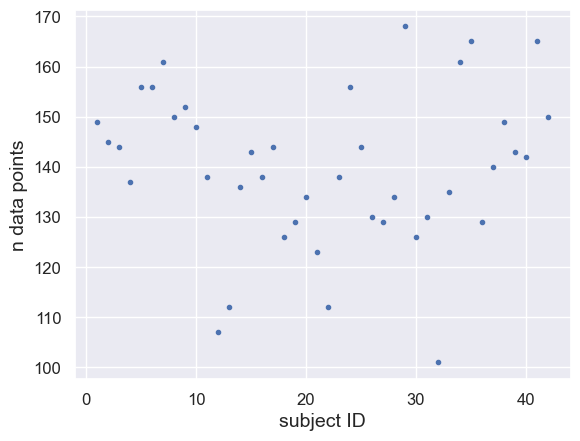

In [159]:
plt.plot(parkinsons_all["subject#"].value_counts(), '.')
plt.xlabel("subject ID")
plt.ylabel("n data points")

There is not a large disparity in number of data points, so I will create the train-test split based on subject ID:

In [160]:
subjects_train, subjects_test = train_test_split(parkinsons_all["subject#"].unique(), test_size=0.2)
df_train = parkinsons_all[parkinsons_all["subject#"].isin(subjects_train)]
df_test = parkinsons_all[parkinsons_all["subject#"].isin(subjects_test)]

In [162]:
#df_train.to_csv(f"{DATA_DIR}/parkinsons_train.csv", index=False)
#df_test.to_csv(f"{DATA_DIR}/parkinsons_test.csv", index=False)

### Loading the saved train_set:
#### We will focus on predicting the motor_UPDRS and so will also drop total_UPDRS for now.

In [165]:
data = pd.read_csv(f"{DATA_DIR}/parkinsons_train.csv")
data = data.drop(columns=["total_UPDRS"])
data.head()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,subject#
0,58,3.866,0.00600,0.000048,0.00302,0.00294,0.00907,0.03866,0.331,0.02058,...,0.02778,0.06175,0.019901,20.632,0.54100,0.75905,0.19288,0,11.078,2
1,58,10.815,0.00810,0.000064,0.00418,0.00457,0.01253,0.04927,0.405,0.02715,...,0.03218,0.08144,0.026285,18.254,0.48799,0.76679,0.22277,0,11.218,2
2,58,17.772,0.00804,0.000062,0.00385,0.00435,0.01155,0.03678,0.324,0.02037,...,0.02621,0.06111,0.024588,18.844,0.49372,0.78209,0.29585,0,11.359,2
3,58,24.808,0.00680,0.000049,0.00350,0.00319,0.01050,0.05083,0.481,0.02733,...,0.03511,0.08198,0.034226,18.272,0.54635,0.73637,0.21570,0,11.501,2
4,58,31.815,0.00375,0.000028,0.00201,0.00209,0.00603,0.03091,0.269,0.01684,...,0.02269,0.05052,0.011958,20.456,0.44009,0.73302,0.18964,0,11.643,2


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            4581 non-null   int64  
 1   test_time      4581 non-null   float64
 2   Jitter(%)      4581 non-null   float64
 3   Jitter(Abs)    4581 non-null   float64
 4   Jitter:RAP     4581 non-null   float64
 5   Jitter:PPQ5    4581 non-null   float64
 6   Jitter:DDP     4581 non-null   float64
 7   Shimmer        4581 non-null   float64
 8   Shimmer(dB)    4581 non-null   float64
 9   Shimmer:APQ3   4581 non-null   float64
 10  Shimmer:APQ5   4581 non-null   float64
 11  Shimmer:APQ11  4581 non-null   float64
 12  Shimmer:DDA    4581 non-null   float64
 13  NHR            4581 non-null   float64
 14  HNR            4581 non-null   float64
 15  RPDE           4581 non-null   float64
 16  DFA            4581 non-null   float64
 17  PPE            4581 non-null   float64
 18  sex     

In [169]:
data.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,subject#
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,...,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000
mean,63.205414,92.043134,0.006158,0.000043,0.003051,0.003317,0.009152,0.034514,0.312977,0.017632,...,0.026981,0.052896,0.034495,21.636239,0.543029,0.653852,0.213273,0.383104,20.534139,21.811177
std,8.965724,52.564493,0.006109,0.000036,0.003397,0.004115,0.010191,0.027925,0.248164,0.014243,...,0.020978,0.042730,0.066670,4.563923,0.105270,0.067153,0.090851,0.486196,8.262344,11.880516
min,36.000000,-3.312500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,...,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000,5.037700,2.000000
25%,57.000000,46.775000,0.003490,0.000021,0.001560,0.001790,0.004690,0.018520,0.169000,0.009090,...,0.014980,0.027280,0.010492,19.292000,0.467700,0.601260,0.150040,0.000000,13.391000,11.000000
50%,63.000000,91.305000,0.004800,0.000034,0.002240,0.002430,0.006710,0.027110,0.246000,0.013720,...,0.021940,0.041160,0.018128,21.915000,0.546900,0.648370,0.199830,0.000000,19.982000,22.000000
75%,68.000000,137.410000,0.006640,0.000052,0.003310,0.003400,0.009920,0.040200,0.365000,0.021240,...,0.031820,0.063710,0.032185,24.590000,0.620390,0.707550,0.258050,1.000000,27.222000,33.000000
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,...,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,1.000000,39.511000,41.000000


### First look at the distributions:

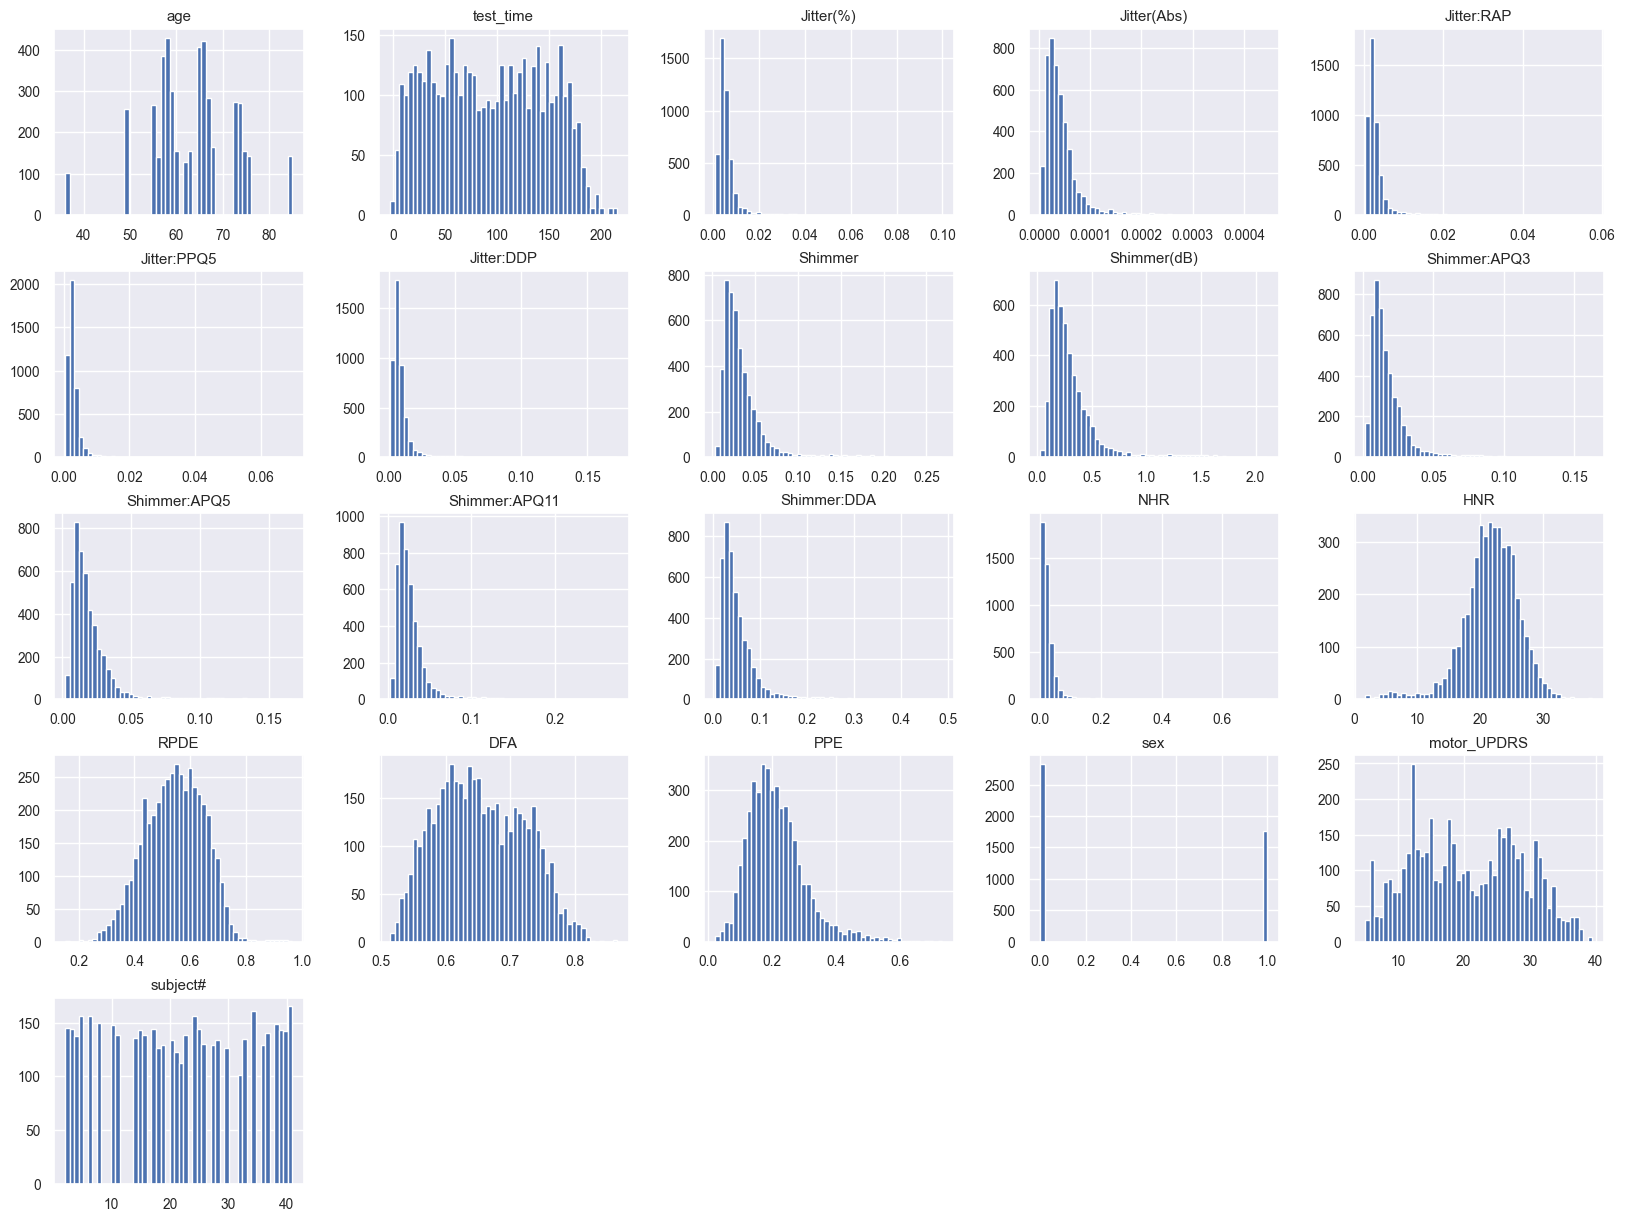

In [170]:
sns.set(font_scale=0.9)
data.hist(bins=50, figsize=(20, 15));

- We see that the jitter and shimmer distributions are right-hand skewed
- DFA is double-peaked, as may be the target, motor_UPDRS
- There are approximately twice as many males as females in the training set (full set had exactly twice as many)

#### I will drop the "test_time" variable now, as I have no explanation for why the time since a participant joined the trial programme would be a predictor for our target variable. It was also not used in the published paper from which this data set originates. 

In [171]:
data = data.drop("test_time", axis=1)

### Let's select some features and plot them against one another, showing male/female in different colours:

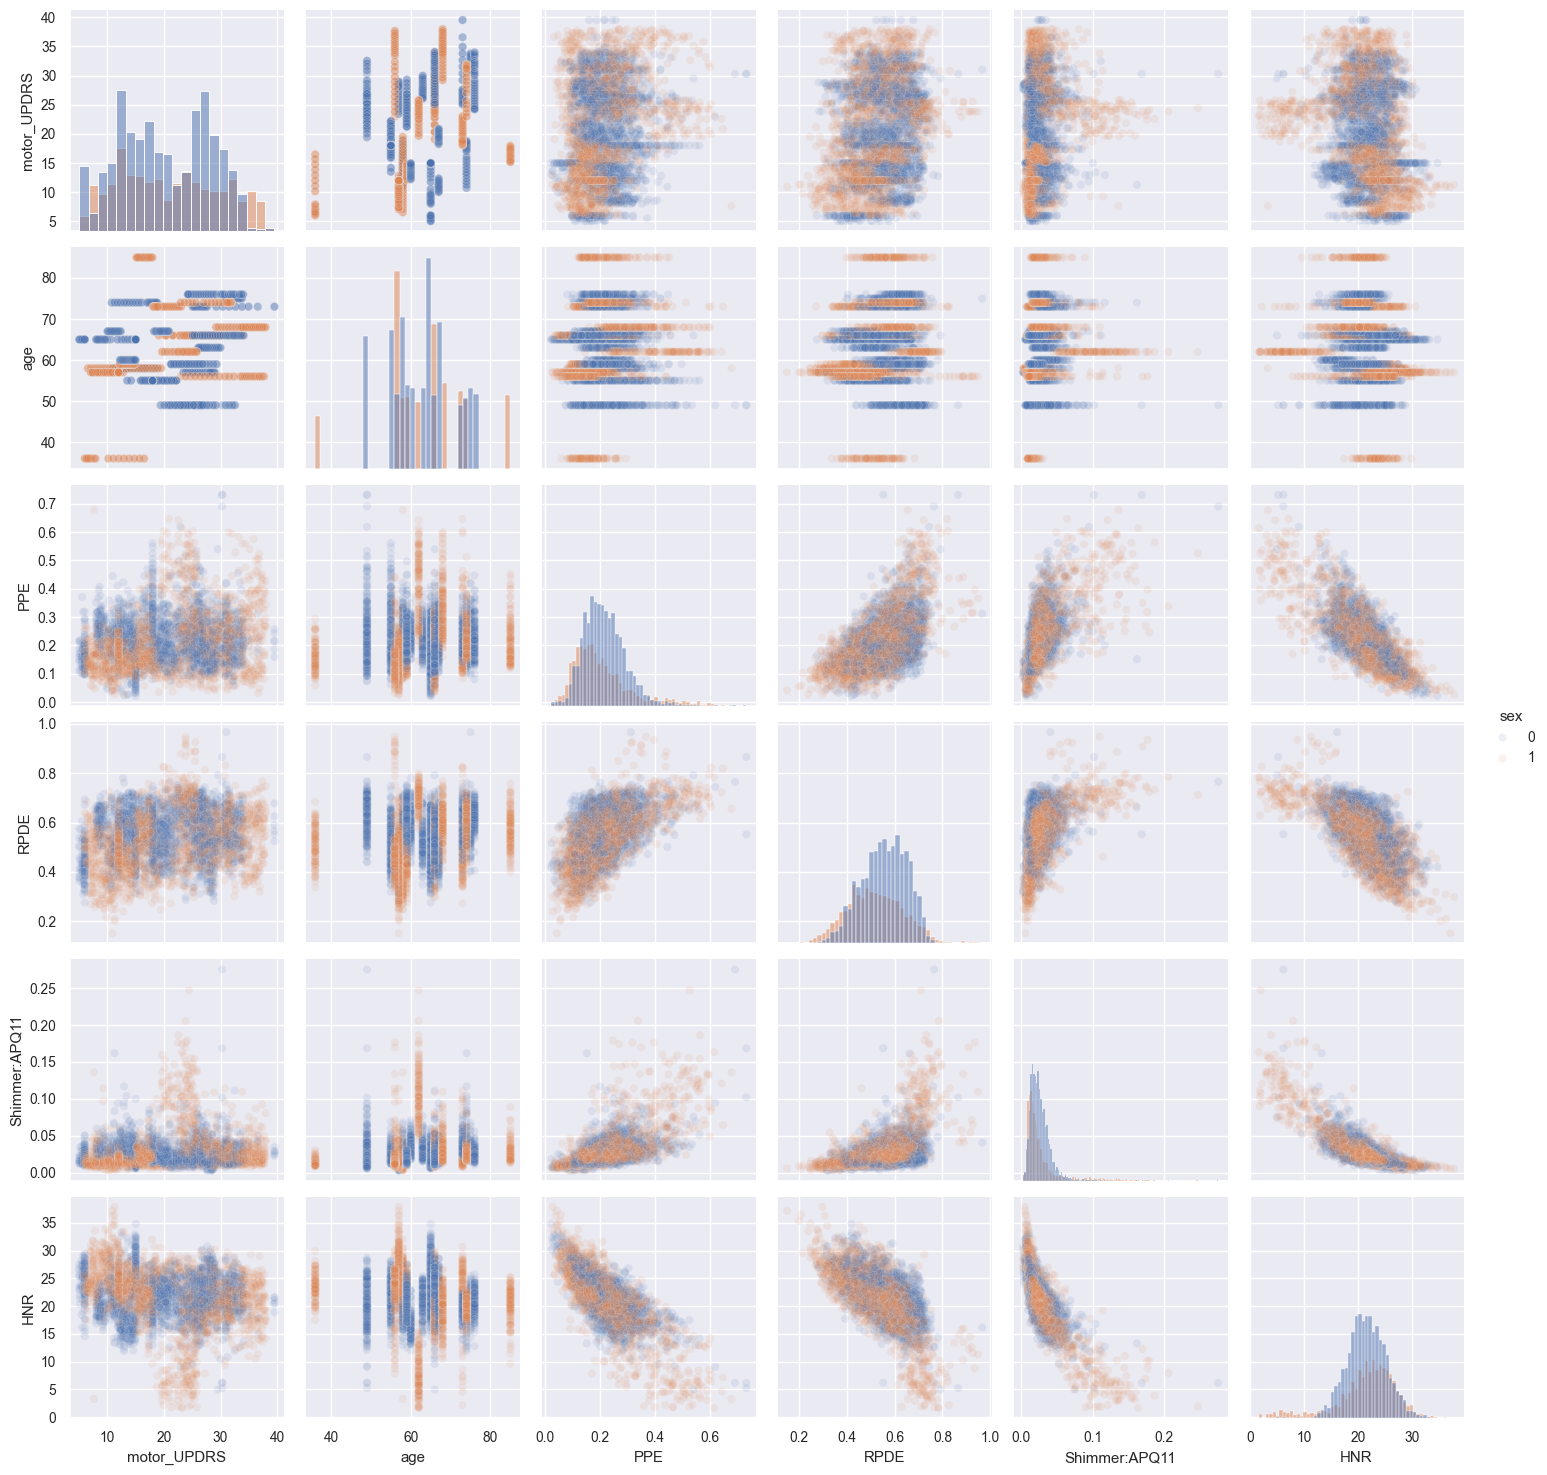

In [172]:
features = ["motor_UPDRS", "age", "PPE", "RPDE", "Shimmer:APQ11", "HNR", "sex"]
sns.pairplot(data[features], kind='scatter', diag_kind='hist', hue="sex", plot_kws=dict(alpha=0.1));

#### The most striking additional insight which the above plots provide is that the outlier points mostly come from female participants.
#### Being female may not of course be the cause, particularly as the number of participants is small and the outlier points seem to come from particular individuals.
#### There are two outlier participants in terms of age: one younger than 40 and one older than 80, who are both female. However, these participants do not display outlier values in terms of the other variables plotted here.

## Correlations

In [173]:
# Compute Pearson correlation coefficient
corr_matrix_p = data.drop(["sex", "subject#"], axis=1).corr(method="pearson")
# Compute Spearman correlation coefficient
corr_matrix_s = data.drop(["sex", "subject#"], axis=1).corr(method="spearman")

- Computing both the Pearson and Spearman coefficients can be interesting.
- If Spearman > Pearson it indicates a monotonic, though less linear correlation - something we will expect to see for the skewed distributions which appeared above.

In [174]:
pearson = corr_matrix_p["motor_UPDRS"].sort_values(ascending=False)
spearman = corr_matrix_s["motor_UPDRS"].sort_values(ascending=False)
pd.concat([pearson, spearman], keys=["pearson", "spearman"], axis=1)

,pearson,spearman
motor_UPDRS,1.000000,1.000000
RPDE,0.236421,0.229439
age,0.229514,0.259058
PPE,0.170471,0.150241
Shimmer:APQ11,0.118952,0.145719
Jitter(%),0.112857,0.150891
NHR,0.112031,0.201932
Jitter:DDP,0.108936,0.141501
Jitter:RAP,0.108927,0.141470
Shimmer(dB),0.107425,0.124714


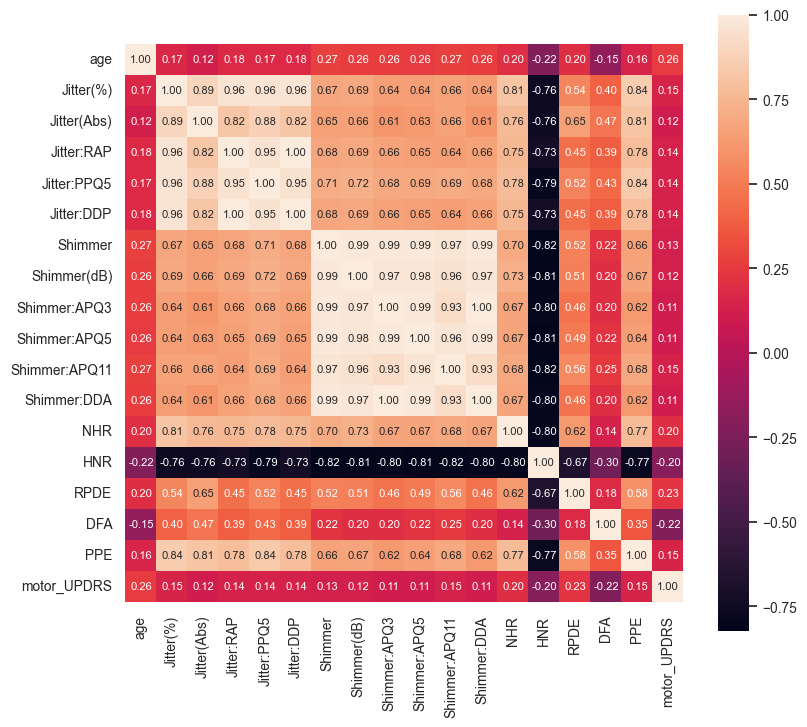

In [176]:
fig, ax = plt.subplots(figsize=(9,8))  
sns.heatmap(corr_matrix_s, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8});


#### None of the measures individually have a large magnitude correlation with motor_UPDRS. That is not to say that the combined (possibly non-linear) relationship between the predictors will not yield accurate predictions.
#### It is evident that we have issues of multicollinearity between variables, which is not surprising given that we have many variants of jitter and shimmer.
#### We will likely want to experiment with eliminating some features, applying regularization, or applying PCA.
#### In the paper referenced at the top of this notebook, the authors found that six features (Jitter (Abs), Shimmer, NHR, HNR, DFA and PPE) gave the best balance between prediction accuracy and model complexity.

#### Now we'll plot the variables against the target:

In [178]:
features = corr_matrix_s["motor_UPDRS"].sort_values(ascending=False).index

#### Seaborn's regplot produces scatter plots with a linear regression model fit:

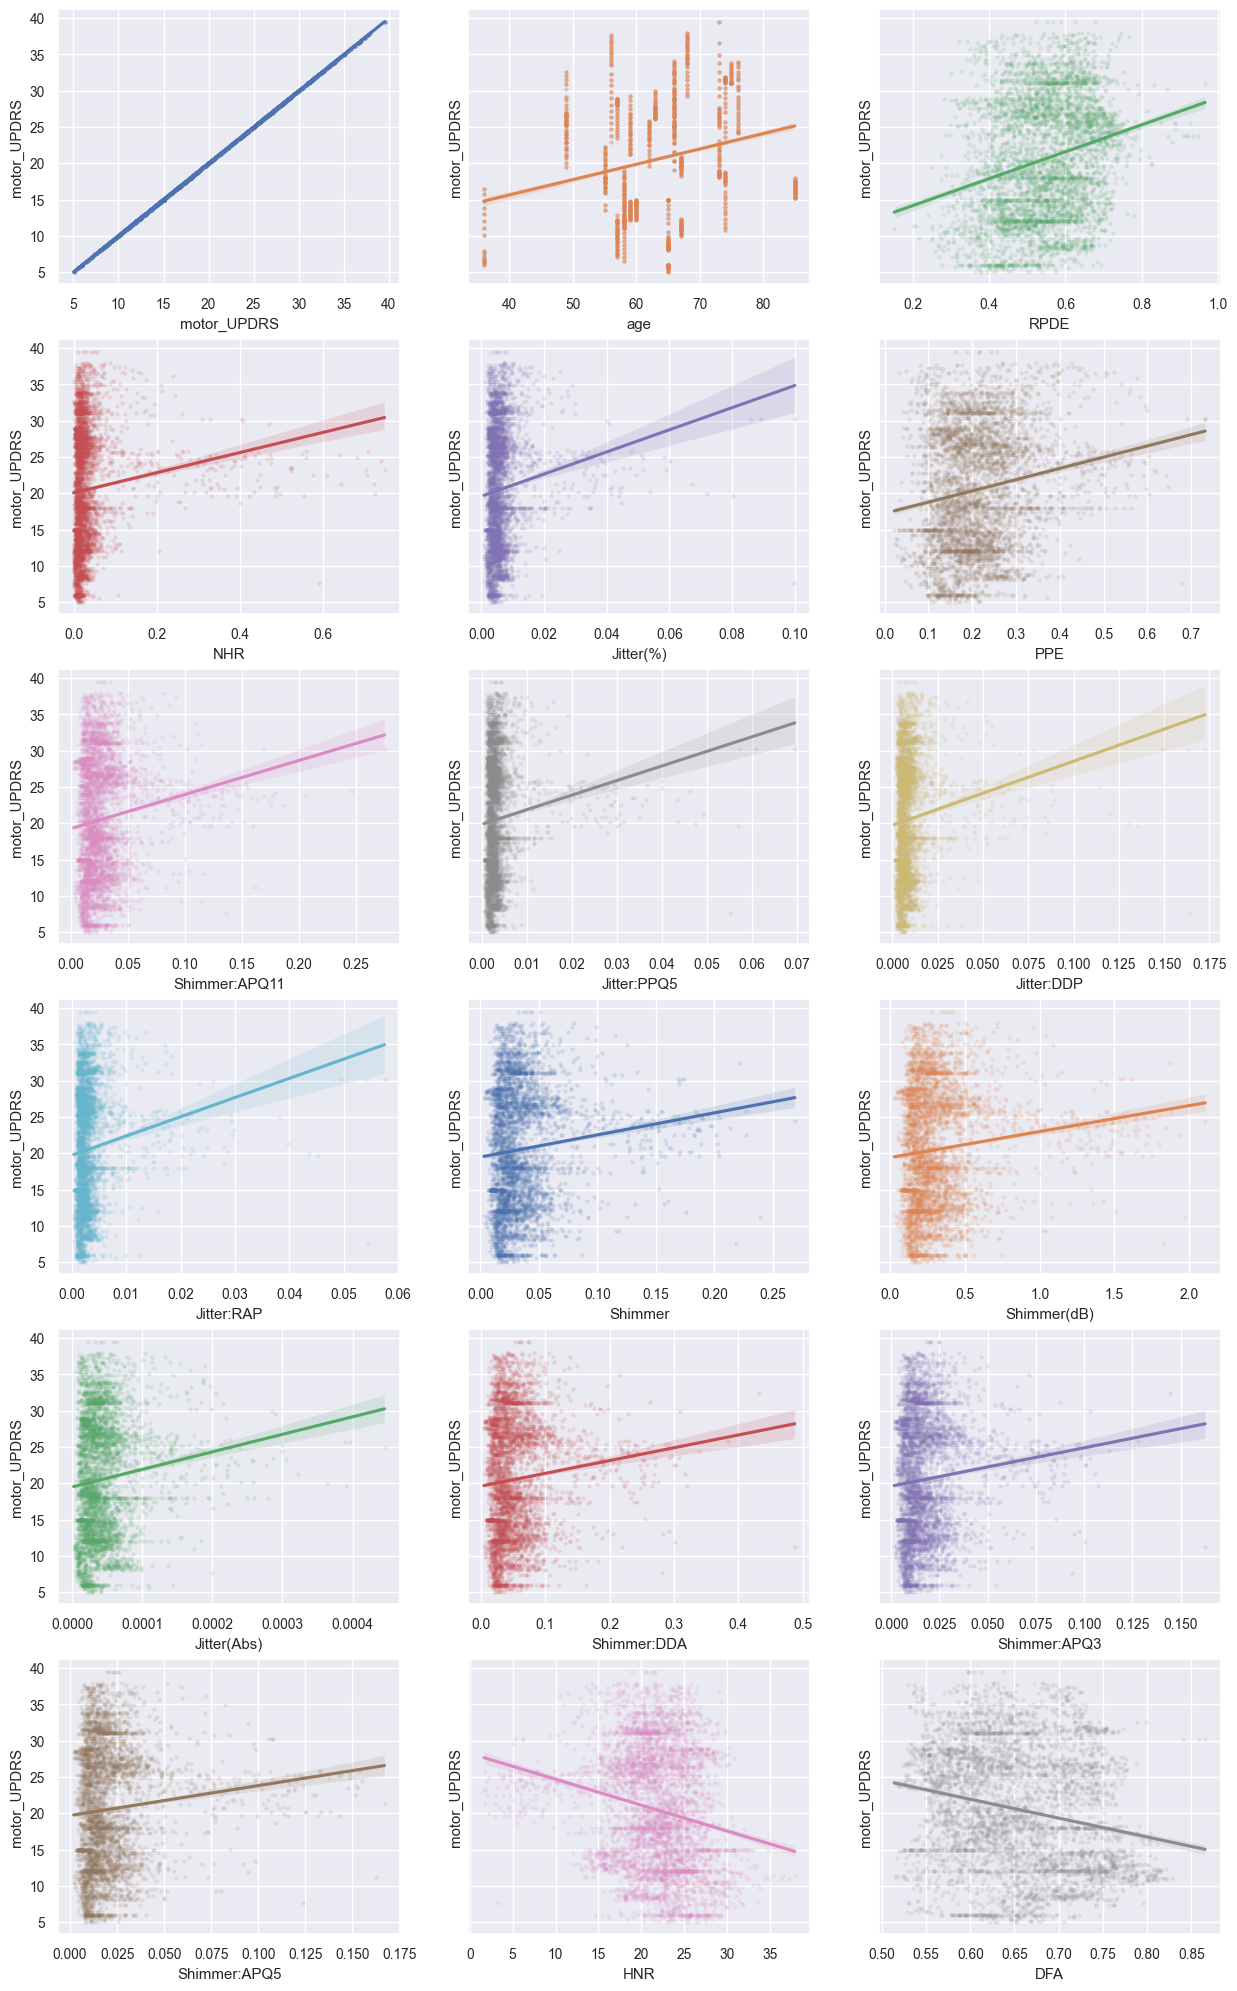

In [179]:
nrow = 6
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(15,25), sharey=True)
for i, ax in enumerate(fig.axes):
    sns.regplot(x=features[i], y='motor_UPDRS', data=data, ax=ax, color=f'C{i}', scatter_kws={'alpha':0.1, 's':5})


## Building a pipeline

### First, we will separate out the target from the predictors.
#### We will also drop the subject IDs, but store them in a new variable for potential use further down the line:

In [180]:
X = data.drop(["motor_UPDRS", "subject#"], axis=1)
y = data["motor_UPDRS"].copy()
subject_ids = data["subject#"].copy()

- We know that there is no missing data and no categorical attributes to handle.
- We may decide to log transform skewed variables, but for a baseline model we will proceed without doing so. 

In [181]:
# Sklearn's pipeline is useful for applying sequences of transformations, although as a baseline
# we will only apply standard scaling.
base_pipeline = Pipeline([
            ('std_scaler', StandardScaler()),
        ])

#### Apply standard scaling to the predictors:

In [182]:
X_scaled = base_pipeline.fit_transform(X)

#### Load some regression models and cross validation scoring from sklearn:

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [219]:
# Create a random number generator state
rng = np.random.RandomState(1)

#### Create a dictionary of models to evaluate:

In [220]:
models = {
    "lin_reg": LinearRegression(),
    "svr": SVR(kernel = 'rbf'),
    "tree_reg": DecisionTreeRegressor(random_state=rng),
    "forest_reg": RandomForestRegressor(random_state=rng),
}

#### The function below will calculate and return the cross_val scores:

In [186]:
def get_cross_val_scores(
    model,
    X,
    y,
    scoring="neg_mean_squared_error",
    folds=10,
    neg_mse_to_rmse=True,
):
    scores = cross_val_score(model, X, y, scoring=scoring, cv=folds)
    if neg_mse_to_rmse:
        scores=np.sqrt(-scores)
    return scores

#### Now we'll run a 10-fold cross validation on our training data set for the three models:

In [187]:
def get_cross_val_score_df(
    model_dict, X, y, scoring="neg_mean_squared_error", folds=10, neg_mse_to_rmse=True
):
    """ Run k-fold cross validation on models supplied in a dictionary.
        Return a dataframe of the scores
    """
    score_dict = {}
    for model in model_dict:
        score_dict[model] = get_cross_val_scores(
            model=model_dict[model],
            X=X,
            y=y,
            scoring=scoring,
            folds=folds,
            neg_mse_to_rmse=neg_mse_to_rmse,
        )
    return pd.DataFrame(score_dict)

#### Let's look at stats on the RMSE of each model:

In [205]:
baseline_rmse = get_cross_val_score_df(model_dict=models, X=X_scaled, y=y)
baseline_rmse.describe()

,lin_reg,svr,tree_reg,forest_reg
count,10.000000,10.000000,10.000000,10.000000
mean,8.498771,9.245304,10.427639,9.481937
std,1.968473,2.456663,2.675668,2.486543
min,6.189217,5.836545,6.678846,6.965825
25%,6.870404,7.838868,8.745029,7.258965
50%,7.967127,8.930881,10.054183,8.938520
75%,9.975187,9.561099,12.395108,11.489399
max,11.534426,14.006696,15.096311,13.225057


- We see that the mean error and its standard deviation are smallest for the linear regression model.

#### Next, we will see what effect log transforming the independent variables with right-hand skewed distributions has.

In [206]:
# Calculate the skew of each variable's distribution
from scipy.stats import skew
skewed_feats = X.drop("sex", axis=1).apply(lambda x: skew(x)) 
skewed_feats

age             -0.144619
Jitter(%)        6.347036
Jitter(Abs)      3.486149
Jitter:RAP       6.750016
Jitter:PPQ5      7.176810
Jitter:DDP       6.749927
Shimmer          3.230560
Shimmer(dB)      3.056019
Shimmer:APQ3     2.991377
Shimmer:APQ5     3.601575
Shimmer:APQ11    3.574863
Shimmer:DDA      2.991378
NHR              5.907773
HNR             -0.841135
RPDE            -0.104173
DFA              0.190156
PPE              1.205341
dtype: float64

#### We will log transform features with skew > 1 and recalcuate baseline scores:

In [207]:
skewed_feats = skewed_feats[skewed_feats > 1]
skewed_feats = skewed_feats.index
X_unskewed = X.copy()
X_unskewed[skewed_feats] = np.log(X_unskewed[skewed_feats])

In [208]:
X_unskewed_scaled = base_pipeline.fit_transform(X_unskewed)

In [209]:
baseline_rmse_unskewed = get_cross_val_score_df(model_dict=models, X=X_unskewed_scaled, y=y)
pd.concat([baseline_rmse, baseline_rmse_unskewed], axis=1).describe()

,lin_reg,svr,tree_reg,forest_reg,lin_reg,svr,tree_reg,forest_reg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,8.498771,9.245304,10.427639,9.481937,8.440641,9.129772,10.425080,9.485263
std,1.968473,2.456663,2.675668,2.486543,1.961379,2.308411,2.679327,2.495500
min,6.189217,5.836545,6.678846,6.965825,5.854158,5.926678,6.673092,6.973103
25%,6.870404,7.838868,8.745029,7.258965,7.073704,7.958069,8.753425,7.253905
50%,7.967127,8.930881,10.054183,8.938520,8.029039,8.568598,10.058766,8.934314
75%,9.975187,9.561099,12.395108,11.489399,9.206135,9.406726,12.397916,11.487343
max,11.534426,14.006696,15.096311,13.225057,11.970123,13.540889,15.094561,13.269535


There are small differences in the RMSE distributions for the lin reg and svr models, but almost no change for the decision tree and random forest models.

## Regularization

It is now worth trying some regularized regression models. Because Lasso Regression tends to eliminate the weights of the least important features, it acts as an automatic feature selection tool. This might be desirable given that we have a lot of features which are correlated with eachother. We will also try ElasticNet and Ridge models.

In [210]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models_reg = {
    "ridge": Ridge(random_state=rng),
    "lasso": Lasso(random_state=rng),
    "elasticnet": ElasticNet(random_state=rng),
}

In [211]:
df_scores_reg = get_cross_val_score_df(model_dict=models_reg, X=X_unskewed_scaled, y=y)

In [212]:
df_scores_reg.describe()

,ridge,lasso,elasticnet
count,10.000000,10.000000,10.000000
mean,8.432236,8.280969,8.161442
std,1.958232,1.381093,1.446080
min,5.860198,7.035054,6.740802
25%,7.068779,7.493084,7.389899
50%,8.012024,7.795412,7.654658
75%,9.202273,8.117207,7.937832
max,11.965125,10.982197,11.001353


#### We see small reductions in the mean RMSE and its scatter.

#### We will return to the above models during hyperparameter tuning stages.
#### We may also want to adopt a different cross-validation setup, which splits based on subject id, as enacted when separating out the test set earlier.

## Learning curves

### It can be informative to look at learning curves for the various models in order to assess over/under fitting issues:

In [213]:
def plot_learning_curves(model, X, y, steps, title):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    train_errors, val_errors = [], []
    training_set_size = []
    for m in range(1, len(X_train) + 1, steps):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        training_set_size.append(len(X_train[:m]))

    plt.plot(training_set_size, np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(training_set_size, np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.title(title)

#### Let's look at the regression and regularized models:

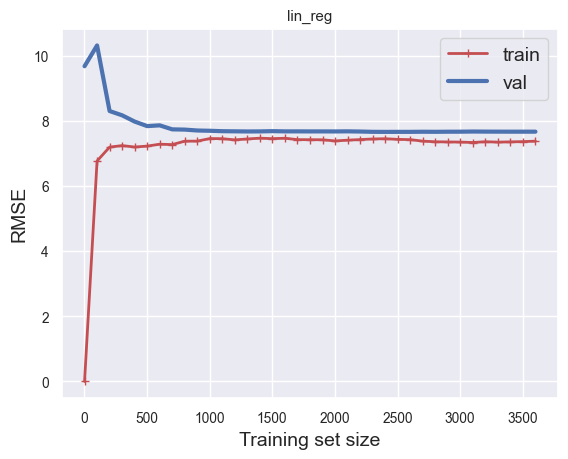

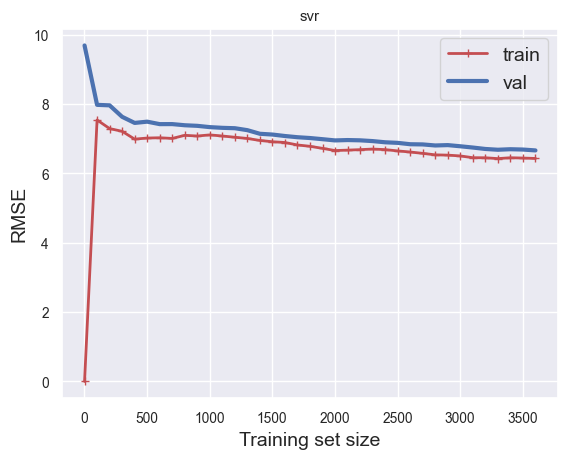

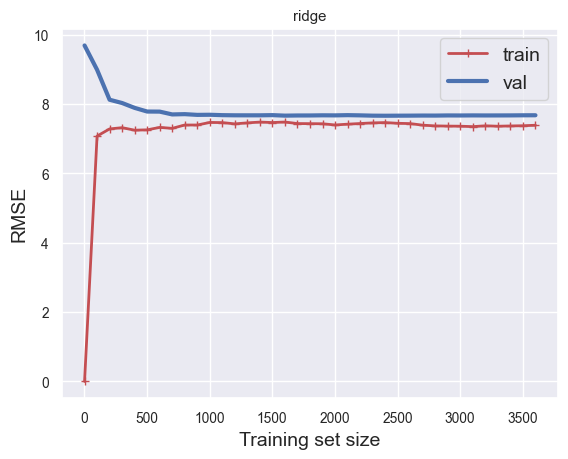

/Users/garethsmith/Development/parkinsons_telemonitoring/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


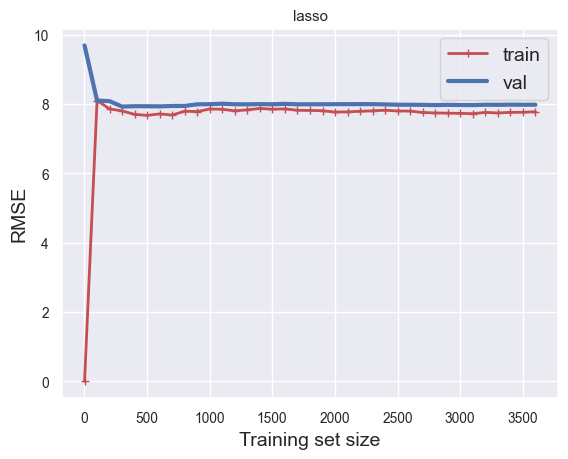

/Users/garethsmith/Development/parkinsons_telemonitoring/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


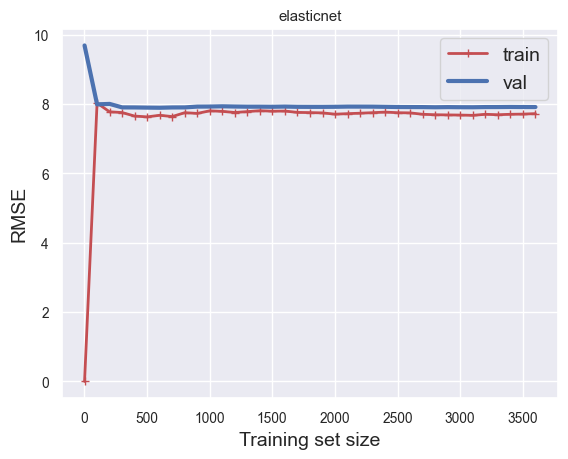

In [217]:
plot_learning_curves(models["lin_reg"], X_scaled, y, steps=100, title="lin_reg")
plt.show()
plot_learning_curves(models["svr"], X_scaled, y, steps=100, title="svr")
plt.show()
plot_learning_curves(models_reg["ridge"], X_scaled, y, steps=100, title="ridge")
plt.show()
plot_learning_curves(models_reg["lasso"], X_scaled, y, steps=100, title="lasso")
plt.show()
plot_learning_curves(models_reg["elasticnet"], X_scaled, y, steps=100, title="elasticnet")
plt.show()

#### The above learning curves all plateau at a high RMSE, close together, which is indicative of underfitting.

### Now, let's look at the learning curves for the decision tree and random forest models:

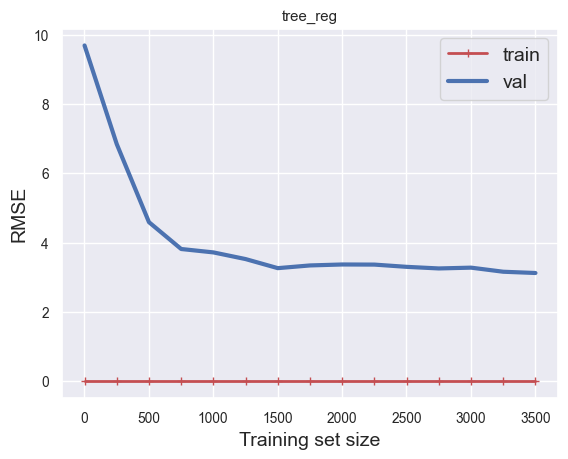

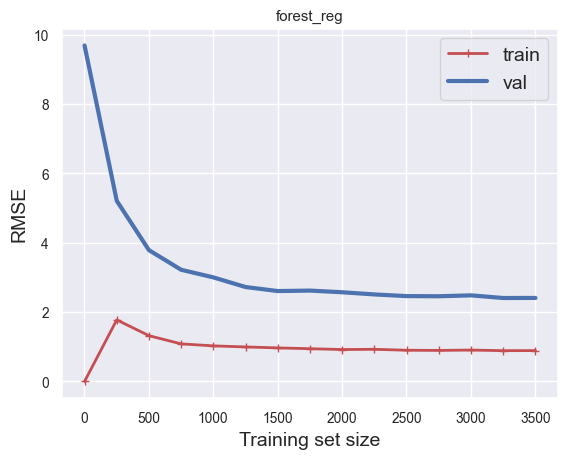

In [216]:
plot_learning_curves(models["tree_reg"], X_scaled, y, steps=250, title="tree_reg")
plt.show()
plot_learning_curves(models["forest_reg"], X_scaled, y, steps=250, title="forest_reg")
plt.show()

#### The decision tree model massively overfits the training set, while the random forest model overfits to a much lesser degree.

### To Do: 
- Hyperparameter tuning
- Investigate feature selection/elimination options
- Investigate alternative cross-validation approaches
- Finalise model
- Evaluate on the test set